# Mental Disorder Classification using Neural Networks

This notebook demonstrates how to build a feed forward neural network (FNN) to classify mental disorders using a dataset from Kaggle.

## Table of Contents
1. Introduction
2. Data Loading and Preprocessing
3. Exploratory Data Analysis (EDA)
4. Neural Network Model
5. Model Training
6. Model Evaluation
7. Conclusion and Future Work

## 1. Introduction
This section provides an overview of the project and the objectives.

## 2. Data Loading and Preprocessing
Import necessary libraries

In [1]:
# Standard libraries
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.subplots as sp
import plotly.graph_objs as go 

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

# TensorFlow and Keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint

# Set seeds for reproducibility
np.random.seed(6594)
tf.random.set_seed(6594)

In [2]:
# Import wandb for experiment tracking and logging
import wandb
from wandb.integration.keras import WandbCallback

# Login to Weights & Biases to track experiments and log metrics
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zcherry (ch3rry). Use `wandb login --relogin` to force relogin


True

### Read in The Data

In [3]:
# Read in the data
disorders = pd.read_csv("clean_data.csv", index_col='subid')

### Data Preprocessing

In [4]:
# Define the mappings for categorical values
mappings = {
    'binary': {'yes': 0, 'no': 1},
    'multi_class': {'most-often': 0, 'usually': 1, 'sometimes': 2, 'seldom': 3}
}

# Define the columns for each mapping type
binary_columns = [
    'mood_swing', 'suicidal_thoughts', 'anorexia', 'authority_respect', 
    'try_explain', 'aggressive_response', 'ignore_move_on', 'nervous_break_down', 
    'admit_mistakes', 'overthinking'
]

multi_class_columns = [
    'sadness', 'euphoric', 'exhausted', 'sleep_dissorder'
]

# Apply the mappings
disorders.replace({col: mappings['binary'] for col in binary_columns}, inplace=True)
disorders.replace({col: mappings['multi_class'] for col in multi_class_columns}, inplace=True)


In [5]:
# Check to make sure that the changes took effect properly
disorders.head(5)

,sadness,euphoric,exhausted,sleep_dissorder,mood_swing,suicidal_thoughts,anorexia,authority_respect,try_explain,aggressive_response,ignore_move_on,nervous_break_down,admit_mistakes,overthinking,sexual_activity,concentration,optimisim,diagnosis
subid,,,,,,,,,,,,,,,,,,
patiant-01,1,3,2,2,0,0,1,1,0,1,1,0,0,0,3,3,4,bipolar type-2
patiant-02,1,3,1,2,1,0,1,1,1,1,1,1,1,1,4,2,5,depression
patiant-03,2,0,2,2,0,1,1,1,0,0,1,0,0,1,6,5,7,bipolar type-1
patiant-04,1,3,1,0,0,0,0,1,0,1,1,1,1,1,3,2,2,bipolar type-2
patiant-05,1,1,2,2,1,1,1,1,1,1,1,0,0,0,5,5,6,no diagnosis


## 3. Exploratory Data Analysis (EDA)
Visualize the distribution of the target variable before splitting the data

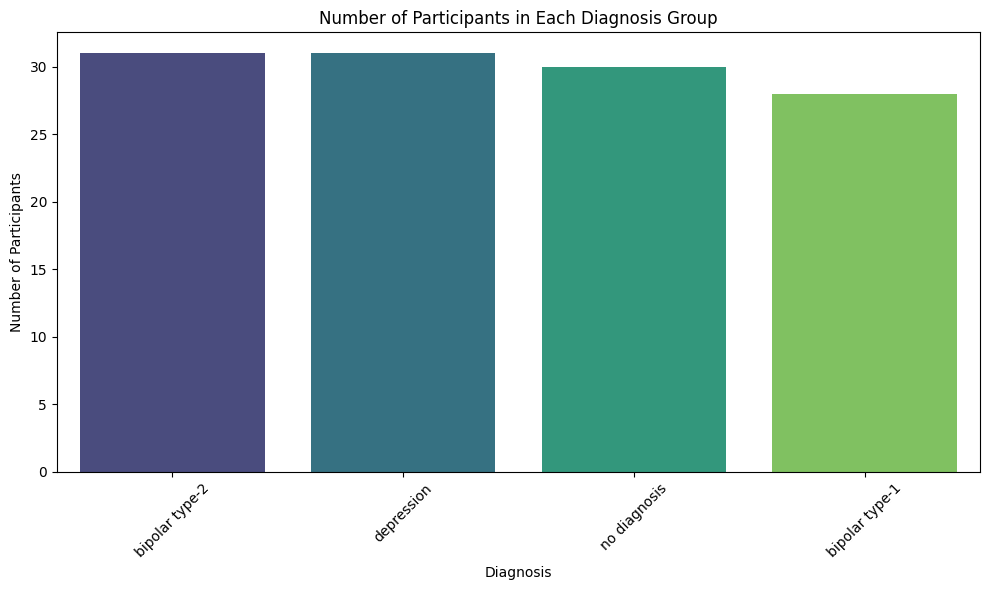

In [6]:
# Count the number of participants in each diagnosis group
diagnosis_counts = disorders['diagnosis'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='viridis')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Participants')
plt.title('Number of Participants in Each Diagnosis Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Separate features and target
X = disorders.drop('diagnosis', axis=1).values
y = disorders['diagnosis'].values

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# Split the data
x_trn, x_test, y_trn, y_test = train_test_split(x_scaled, y_categorical, test_size=0.2, random_state=6594)

# Examine the distribution of diagnoses in the training set
# Convert y_trn from one-hot encoded format to integer labels
y_trn_labels = np.argmax(y_trn, axis=1)
# Count the occurrences of each diagnosis
label_counts = np.bincount(y_trn_labels)
diagnosis_labels = label_encoder.classes_

In [8]:
print("x training is of type " + str(type(x_trn)))
print("y training is of type " + str(type(y_trn)))

print("x training contains data of type " + str(x_trn.dtype))
print("y training contains data of type " + str(y_trn.dtype))

print("x training has shape " + str(x_trn.shape))
print("y training has shape " + str(y_trn.shape))

x training is of type <class 'numpy.ndarray'>
y training is of type <class 'numpy.ndarray'>
x training contains data of type float64
y training contains data of type float64
x training has shape (96, 17)
y training has shape (96, 4)


## 4. Neural Network Model

### Define the Sweep

In [9]:
# Define the sweep
sweep_config = {
    'method': 'random',  # or 'grid', 'bayes'
    'parameters': {
        'epochs': {'values': [30, 50, 70, 100, 150, 300, 600]},
        'batch_size': {'values': [16, 32, 64, 128]},
        'learning_rate': {'values': [0.0001, 0.001, 0.01, 0.1]},
        'num_layers': {'values': [1, 2, 3]},
        'units_layer_1': {'values': [32, 64, 128, 256]},
        'units_layer_2': {'values': [32, 64, 128, 256]},
        'dropout_rate': {'values': [0.2, 0.3, 0.5, 0.7]},
    }
}

# Initialize wandb
wandb.init(project='mental-disorder-classification')

### Build the Model

In [10]:
# Define the model architecture function
def build_model():
    model = Sequential()
    
    units_layer_1 = wandb.config.get('units_layer_1', 64)
    units_layer_2 = wandb.config.get('units_layer_2', 64)
    dropout_rate = wandb.config.get('dropout_rate', 0.5)
    num_layers = wandb.config.get('num_layers', 1)
    learning_rate = wandb.config.get('learning_rate', 0.001)
    
    model.add(Dense(units_layer_1, input_dim=x_trn.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    
    if num_layers > 1:
        model.add(Dense(units_layer_2, activation='relu'))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(y_categorical.shape[1], activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Define the training function
def train():
    try:
        model = build_model()
        history = model.fit(x_trn, y_trn, 
                            validation_data=(x_test, y_test), 
                            epochs=wandb.config.get('epochs', 30), 
                            batch_size=wandb.config.get('batch_size', 32), 
                            callbacks=[WandbCallback()])
        
        # Evaluate the model
        loss, accuracy = model.evaluate(x_test, y_test)
        wandb.log({'validation_loss': loss, 'validation_accuracy': accuracy})
    except Exception as e:
        wandb.log({'error': str(e)})
        print(f"An error occurred: {e}")

In [ ]:
# Run the sweep
sweep_id = wandb.sweep(sweep_config, project='mental-disorder-classification')
wandb.agent(sweep_id, train) 

## 5. Model Training
Train the model

## 6. Model Evaluation
Evaluate the model on the test set

In [ ]:
#Look at the training loss over time using the plot function from matplotlib loaded above:
plt.plot(H.history['loss'])

In [ ]:
rum.predict(x=xtrn)

In [ ]:
#Code here for analyzing model behavior
#As an example, let's look at xor model internal representations

#Create new model from parts of trained model to output hidden unit activations
xrep = Model(inputs=xin, outputs=xhid)

#Use this model to output hidden activations for the four input patterns
xrep.predict(xtrn)

In [ ]:
# Sample predictions and actual values
predictions = sym.predict([input_test, query_test])

# Create main figure and axes
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1]) 

# Main plot area
ax_main = fig.add_subplot(gs[0, 0])
ax_main.plot(predictions[:, 0], 'o', label='Predicted Values', color='blue')
ax_main.plot(att_patts[:, 0], 'x', label='Actual Values', color='red')
ax_main.set_xlabel('Index')
ax_main.set_ylabel('Values')
ax_main.set_title('Predicted and Actual Values')
ax_main.legend()
ax_main.grid(True)

## 7. Conclusion and Future Work
Summarize findings and discuss potential improvements